# Get multibolid data



In [3]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [4]:
multibolid_id = 1488735

In [5]:
bz = Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 6


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [6]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['filepath', 'id_server', 'url_file_raw', 'magnitude', 'observatory_namesimple', 'url_station', 'event_id', 'url_file_js9', 'url_file', 'peak_f', 'filename', 'filename_raw', 'station_name', 'namesimple', 'id_observer', 'duration', 'noise', 'observatory_name', 'obstime', 'file_status']

{'filepath': '/storage/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07', 'id_server': 1, 'url_file_raw': 'http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924074938639_VALMEZ-R1_raws.fits', 'magnitude': 20.5056, 'observatory_namesimple': 'valmez', 'url_station': 'http://api.vo.astro.cz/bolidozor/getStation/?id=30', 'event_id': 803356, 'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924074938639_VALMEZ-R1_met.fits', 'url_file': 'http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924074938639_VALMEZ-R1_met.fits', 'peak_f': 26494.6, 'filename': '20170924074938639_VALMEZ-R1_met.fit

Nahrát data do cache

In [7]:
for i, bolid in enumerate(bolids.result):
    print(i+1,'z',len(bolids.result))
    fits.open(bolid['url_file_raw'])

1 z 6
2 z 6
3 z 6
4 z 6
5 z 6
6 z 6


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [8]:
def timeCalibration(raw_file, sigma = 15, debug = True):
    calibration_data = {}
    hdulist = fits.open(raw_file, cache=True)
    met_data = np.abs(np.ravel(hdulist[0].data))
    clip_val = np.std(met_data)*sigma
    plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    for i, point in enumerate(met_data):
        if point > clip_val:
            plt.axvline(x=i, color='red')
            ten_sec = 10/(hdulist[0].header['CDELT2']/2/1000.0)
            if debug: plt.axvline(x=i+ten_sec, color='green')
            break
    file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    DATE = datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" )
    
    gps = (DATE-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
    round_gps = round(gps/10.0)*10
    correction = datetime.timedelta(seconds=round_gps-gps)

    calibration_data['sys_correction'] = correction
    
    calibration_data['sys_file_beg'] = DATE-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE
    calibration_data['sys_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE+correction
    calibration_data['cor_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    calibration_data['cor_error'] = correction
    
    if debug:
        file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
        time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
        #DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni vzorku s GPS :', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', correction)
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        plt.plot(met_data)
        plt.show()
    return calibration_data
        

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

Pokud je zapnuté debugování, tak ze skriptu vypadávají tato data:

delka zaznamu          : Délka záznamu
cas prvni vzorku s GPS : 
cas 1. GPS a konec     : Vzdálenost první detekované GPS ke konci souboru
SysCas ukladani souboru: Čas z hlavičky FITSu ['DATE']
SysCas zacatku souboru : Čas z hlavičky ['DATE'] mínus délka souboru
SysCas 1. GPS znacky   : Systémový čas stanice v okamžiku GPS značky
Korekce systémoveho čas: Systémový čas 
CorCas ukladani souboru: 2017-09-23 07:24:19.241618 s
CorCas zacatku souboru : 2017-09-23 07:24:06.241614
CorCas 1. GPS znacky   : 2017-09-23 07:24:10

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924074938639_VALMEZ-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924074938639_VALMEZ-R1_raws.fits
delka zaznamu          : 46.800014976 s
cas prvni vzorku s GPS : 0.457057437925 s
cas 1. GPS a konec     : 46.342957538075 s
SysCas ukladani souboru: 2017-09-24 07:50:00 s
SysCas zacatku souboru : 2017-09-24 07:49:13.199985
SysCas 1. GPS znacky   : 2017-09-24 07:49:13.657042
Korekce systémoveho čas: -1 day, 23:59:56.342958
CorCas ukladani souboru: 2017-09-24 07:49:56.342958 s
CorCas zacatku souboru : 2017-09-24 07:49:09.542943
CorCas 1. GPS znacky   : 2017-09-24 07:49:10


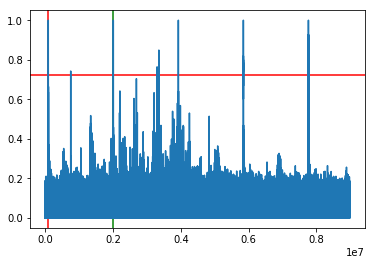

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/24/07/20170924074925612_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/24/07/20170924074925612_HFN-R1_raws.fits
delka zaznamu          : 44.600014272 s
cas prvni vzorku s GPS : 9.48048220042 s
cas 1. GPS a konec     : 35.119532071580004 s
SysCas ukladani souboru: 2017-09-24 07:50:00 s
SysCas zacatku souboru : 2017-09-24 07:49:15.399986
SysCas 1. GPS znacky   : 2017-09-24 07:49:24.880468
Korekce systémoveho čas: -1 day, 23:59:55.119532
CorCas ukladani souboru: 2017-09-24 07:49:55.119532 s
CorCas zacatku souboru : 2017-09-24 07:49:10.519518
CorCas 1. GPS znacky   : 2017-09-24 07:49:20


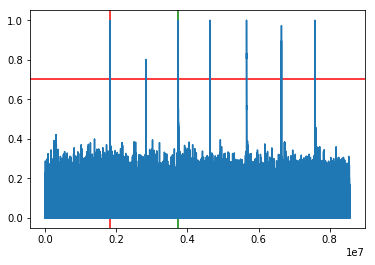

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/24/07/20170924074946846_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/24/07/20170924074946846_DDMTREBIC-R3_raws.fits
delka zaznamu          : 48.00001536 s
cas prvni vzorku s GPS : 9.57512806404 s
cas 1. GPS a konec     : 38.42488729596 s
SysCas ukladani souboru: 2017-09-24 07:50:02 s
SysCas zacatku souboru : 2017-09-24 07:49:13.999985
SysCas 1. GPS znacky   : 2017-09-24 07:49:23.575113
Korekce systémoveho čas: -1 day, 23:59:56.424887
CorCas ukladani souboru: 2017-09-24 07:49:58.424887 s
CorCas zacatku souboru : 2017-09-24 07:49:10.424872
CorCas 1. GPS znacky   : 2017-09-24 07:49:20


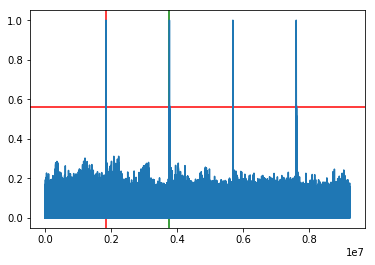

3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/24/07/20170924075004012_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/24/07/20170924075004012_HFN-R1_raws.fits
delka zaznamu          : 3.2000010239999996 s
cas prvni vzorku s GPS : 3.199995815665 s
cas 1. GPS a konec     : 5.208334999728947e-06 s
SysCas ukladani souboru: 2017-09-24 07:50:03 s
SysCas zacatku souboru : 2017-09-24 07:49:59.799999
SysCas 1. GPS znacky   : 2017-09-24 07:50:02.999995
Korekce systémoveho čas: -1 day, 23:59:57.000005
CorCas ukladani souboru: 2017-09-24 07:50:00.000005 s
CorCas zacatku souboru : 2017-09-24 07:49:56.800004
CorCas 1. GPS znacky   : 2017-09-24 07:50:00


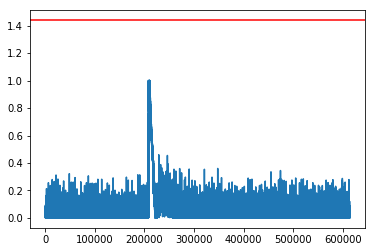

4 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/24/07/20170924074920754_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/24/07/20170924074920754_SVAKOV-R12_raws.fits
delka zaznamu          : 51.800016576 s
cas prvni vzorku s GPS : 1.26963582295 s
cas 1. GPS a konec     : 50.53038075305 s
SysCas ukladani souboru: 2017-09-24 07:50:03 s
SysCas zacatku souboru : 2017-09-24 07:49:11.199983
SysCas 1. GPS znacky   : 2017-09-24 07:49:12.469619
Korekce systémoveho čas: -1 day, 23:59:57.530381
CorCas ukladani souboru: 2017-09-24 07:50:00.530381 s
CorCas zacatku souboru : 2017-09-24 07:49:08.730364
CorCas 1. GPS znacky   : 2017-09-24 07:49:10


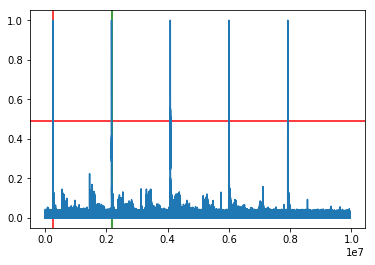

5 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924075017039_VALMEZ-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/24/07/20170924075017039_VALMEZ-R1_raws.fits
delka zaznamu          : 6.600002111999999 s
cas prvni vzorku s GPS : 2.0565631581 s
cas 1. GPS a konec     : 4.543438953899999 s
SysCas ukladani souboru: 2017-09-24 07:50:04 s
SysCas zacatku souboru : 2017-09-24 07:49:57.399998
SysCas 1. GPS znacky   : 2017-09-24 07:49:59.456561
Korekce systémoveho čas: 0:00:00.543439
CorCas ukladani souboru: 2017-09-24 07:50:04.543439 s
CorCas zacatku souboru : 2017-09-24 07:49:57.943437
CorCas 1. GPS znacky   : 2017-09-24 07:50:00


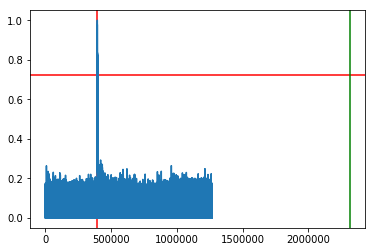

In [9]:

for i, bolid in enumerate(bolids.result):
    print(i,"==================================")
    print("snapshot:", bolid['url_file_js9'])
    bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'])
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [14]:
time_offset = {}
selected = range(0, len(bolids.result))     # vyber vsech dat

selected = [0,1,4]

#selected = [3,4,5,6]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

# time_offset[0] = +0   ## Posun času na stanici.
                        # Timto posunete data pro určitou stanici (podle indexu souboru)
                        # o určitý počet časových značek (10s intervalů)
                        # Kladné číslo posune graf 'nahoru" 
#time_offset[0]=0
#time_offset[4]=-1
for i, bolid in enumerate(bolids.result):
    if i in selected:
        print(i, ',sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['cor_error'], bolid['filename'])

0 ,sysT of gps: 2017-09-24 07:49:10 ,offset: -1 day, 23:59:56.342958 20170924074938639_VALMEZ-R1_met.fits
1 ,sysT of gps: 2017-09-24 07:49:20 ,offset: -1 day, 23:59:55.119532 20170924074925612_HFN-R1_met.fits
4 ,sysT of gps: 2017-09-24 07:49:10 ,offset: -1 day, 23:59:57.530381 20170924074920754_SVAKOV-R12_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

0 2017-09-24 07:49:09.542943
1 2017-09-24 07:49:10.519518
2 2017-09-24 07:49:08.730364
1506239348.730364 1506239400.530381


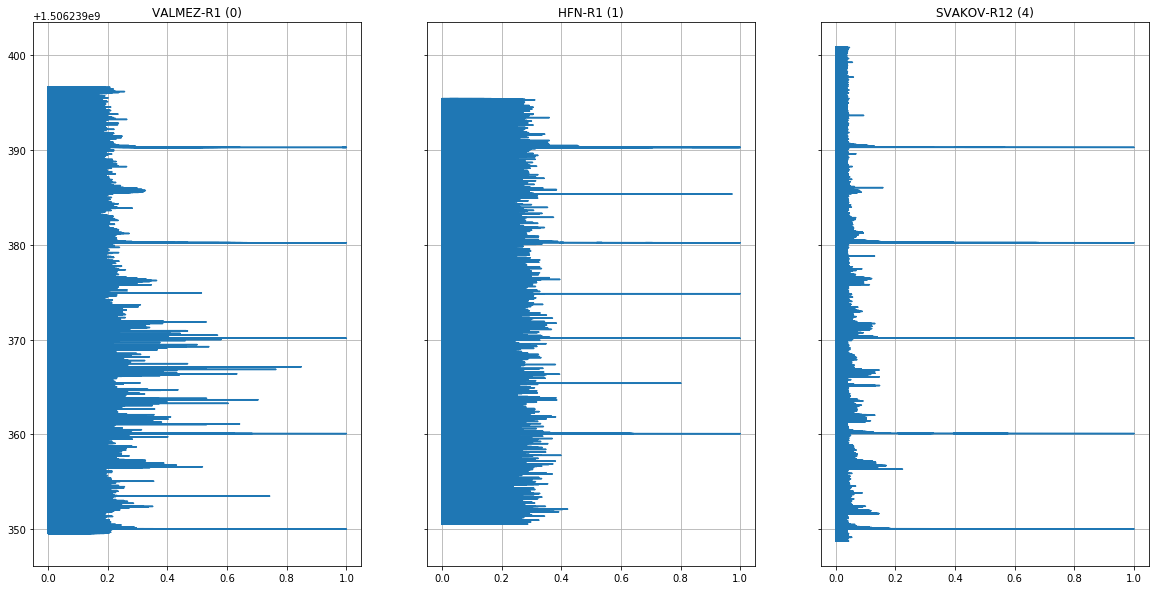

In [15]:
%matplotlib inline 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    print (i, bolid['time_calib']['cor_file_beg'])
    hdulist = fits.open(bolid['url_file_raw'])
    met_data = np.abs(np.ravel(hdulist[0].data))
    
    T_offset = 10*time_offset.get(selected[i], 0)
    
    if gps_calib:
        min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    else:
        min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))
    
    if not minimal_time: minimal_time = min_date
    if not maximal_time: maximal_time = max_date
    if min_date < minimal_time: minimal_time = min_date
    if max_date > maximal_time: maximal_time = max_date
    
    ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+")")
    ax.plot(met_data, array)
    ax.grid(True)

fig.subplots_adjust(hspace=0)
print(minimal_time, maximal_time)

In [16]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

{}


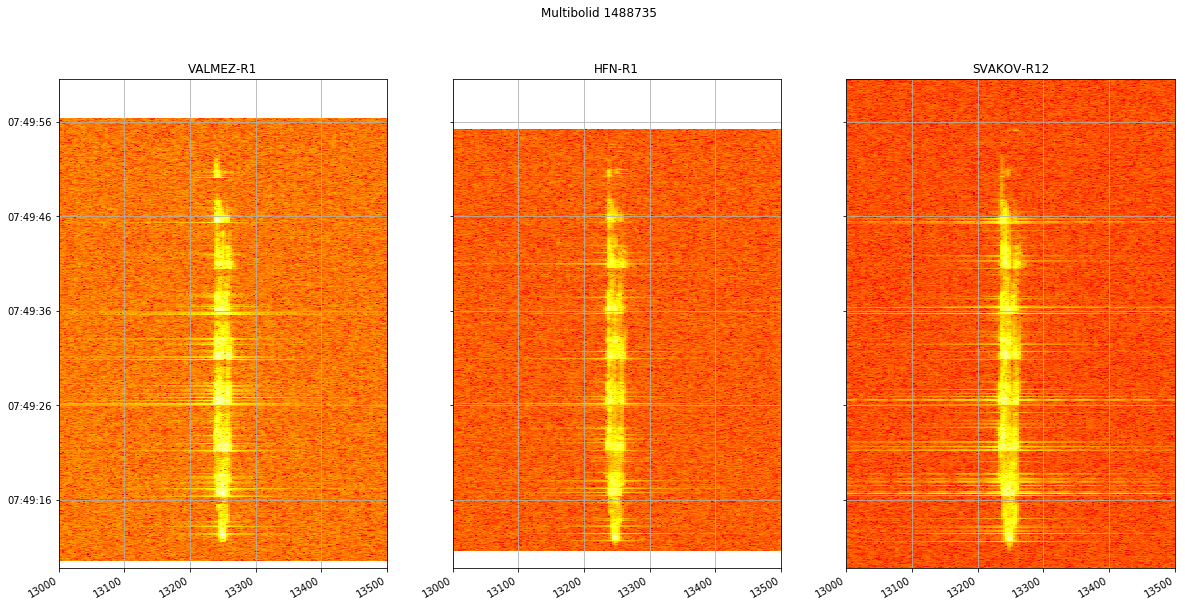

In [17]:
%matplotlib inline 
#%matplotlib notebook
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

print(time_offset)
fig.suptitle("Multibolid %s" %(multibolid_id))
fig.subplots_adjust(hspace=0)
plt.set_cmap('hot')
for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    T_offset = datetime.timedelta(seconds = 10*time_offset.get(selected[i], 0))
    #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
    d1 = bolid['time_calib']['cor_file_beg']+T_offset
    fds1 = dates.date2num(d1) # converted
    d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/48000.0/2)
    fds2 = dates.date2num(d2)
    
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 48000, bins = 4096*4)
    ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-24000, 24000, fds2, fds1])
    ax.grid(True)
    
    ax.set_xlim(13000,13500)
    ax.yaxis_date()
    date_format = md.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))
    
    offset = abs(bolid['time_calib']['cor_error']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
    if bolid['time_calib']['cor_error'] < datetime.timedelta(seconds=0): offset = -offset
    #ax.set_title(bolid['namesimple']+ " err:"+str(offset))
    ax.set_title(bolid['namesimple'])
